In [ ]:
#|hide
from nbdev.showdoc import *

# Building a Binary Classifier

> In this example, the moons dataset is used to build a binary classifier.

In [ ]:
#|hide
# Setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss

torch.manual_seed(0)  #  for repeatable results

<torch._C.Generator>

In [ ]:
def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)

def angle2class(x: torch.tensor, categories:int, periodicity:int) -> torch.tensor:
    tmp = x.angle() + 2 * np.pi
    angle = torch.remainder(tmp, 2 * np.pi)

    # This will be the discrete output (the number of sector)
    o = torch.floor(categories * periodicity * angle / (2 * np.pi))
    return torch.remainder(o, categories)

## Dataset
In this example the moons dataset is used to build a binary classifcator. The aim is to find the boundary beetween two cresecent moons. The entire data set consists of 1500 data points and is shown in the image below. 

In [ ]:
# hide
n_samples = 1500
X, y = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=42)

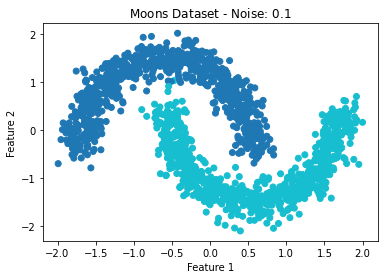

In [ ]:
# hide_input
#%matplotlib widget
X = StandardScaler().fit_transform(X)
# X = transform(X, alpha=np.pi / 8)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10")
plt.title("Moons Dataset - Noise: $0.1$")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

## MLMVN

In [ ]:
class MLMVN(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_linear = FirstLayer(2, 4)
        self.phase_act1 = cmplx_phase_activation()
        # self.hidden_linear = HiddenLayer(4, 4)
        # self.phase_act2 = cmplx_phase_activation()
        self.output_linear = OutputLayer(4, 1)
        self.phase_act3 = cmplx_phase_activation()

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        # x = self.hidden_linear(x)
        # x = self.phase_act2(x)
        x = self.output_linear(x)
        x = self.phase_act3(x)
        return x
    
    def predict(self, x, loss):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return output

    # Implement the train function given a training dataset X and correcsponding labels y
def train(
    model,
    X,
    y,
    epochs,
    batch_size,
    optimizer,
    criterion,
    categories,
    periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    list_weights = []
    list_bias = []
    list_outputs = []
    list_self_adjusting_learning_rate = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]


            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)

            loss = criterion(y_pred.view(-1), yb, categories, periodicity)
            # wandb.log({"loss": torch.abs(loss)})
            
            if i % 10 == 9: print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(sum(batch_loss)/len(batch_loss))
        y_pred = model(X)
        y_pred = angle2class(y_pred, categories, periodicity)
        scores.append(accuracy(y_pred.squeeze(), y))

    return (
        losses,
        scores,
        list_weights,
        list_bias,
        list_outputs,
        list_self_adjusting_learning_rate,
    )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Convert numpy arrays into torch tensors
X_train_t, y_train_t, X_test_t, y_test_t = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_train_t = X_train_t.type(torch.cdouble)
X_test_t = X_test_t.type(torch.cdouble)

In [ ]:
model = MLMVN()
criterion = ComplexMSELoss.apply
optimizer = torch.optim.SGD(model.parameters(), lr=1)
categories =  2
periodicity = 1

In [ ]:
(
    losses,
    scores,
    list_weights,
    list_bias,
    list_outputs,
    list_self_adjusting_learning_rate,
) = train(model, X_train_t, y_train_t, epochs=100, batch_size=100, optimizer=optimizer, criterion=criterion, categories=categories, periodicity=periodicity)

tensor(0.6178, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.7398, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4988, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.6403, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.5458, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.9955, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4657, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.7256, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3686, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2863, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2915, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2846, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.3829, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2679, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4899, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2295, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.4722, dtype=torch.float64, grad

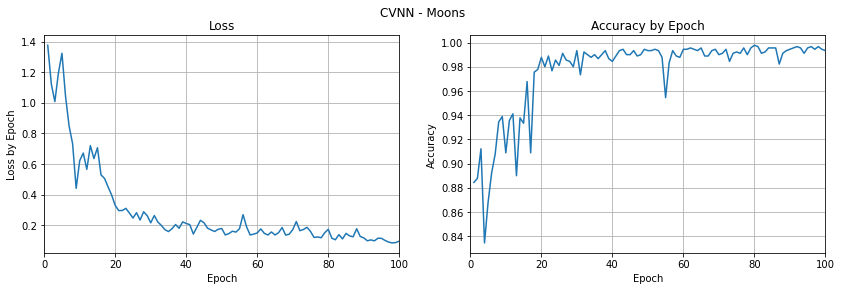

In [ ]:
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss by Epoch")
    ax1.set_title("Loss")
    ax1.set_xlim(0, len(losses))

    ax2.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy by Epoch")
    ax2.set_xlim(0, len(losses))

    plt.show()

plot_loss(
    "CVNN - Moons",
    losses,
    scores
    )

In [ ]:
y_pred = model(X_train_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_train_t)
acc

0.9933333333333333

In [ ]:
y_pred = model(X_test_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_test_t)
acc

0.9883333333333333